# Creating a Kaggle Workflow

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [2]:
train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")

In [3]:
train.shape

(891, 12)

In [5]:
holdout.shape

(418, 11)

In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Preprocessing Kaggle Data

In [11]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [12]:
def preprocess(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    selected_cols = ["Age_categories","Fare_categories","Title","Cabin_type","Sex"]

    for col in selected_cols:
        df = create_dummies(df,col)
    
    return df

In [13]:
train = preprocess(train)
holdout = preprocess(holdout)

In [14]:
train.shape

(891, 43)

In [15]:
holdout.shape

(418, 41)

In [16]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,0,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,1,0,0,0,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,0,1,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,1,0,0,0,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0,0,0,0,1,0,1


## Exploring and Visualizing the Data

In [17]:
train["SibSp"].dtypes

dtype('int64')

In [18]:
train["Parch"].dtypes

dtype('int64')

In [22]:
train[["SibSp","Parch"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
SibSp    891 non-null int64
Parch    891 non-null int64
dtypes: int64(2)
memory usage: 14.0 KB


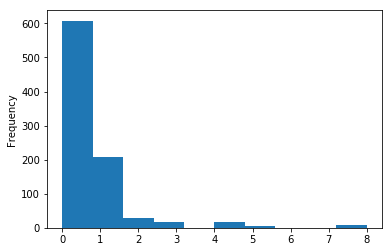

In [23]:
train["SibSp"].plot.hist()
plt.show()

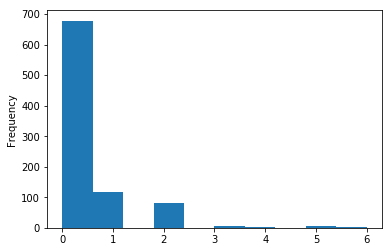

In [24]:
train["Parch"].plot.hist()
plt.show()

In [33]:
sibsp_pivot = train.pivot_table(values="Survived", index="SibSp")
sibsp_pivot

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


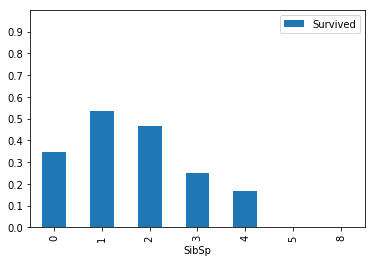

In [34]:
sibsp_pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
plt.show()

In [35]:
parch_pivot = train.pivot_table(values="Survived", index="Parch")
parch_pivot

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


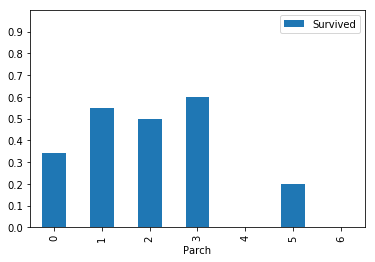

In [36]:
parch_pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
plt.show()

## Feature Engineering

In [45]:
def isalone(df):
    df["isalone"] = df.apply(lambda row: 1 if row["SibSp"] == 0 and row["Parch"]==0 else 0, axis=1)
    return df

In [46]:
train = isalone(train)
holdout = isalone(holdout)

In [47]:
train.shape

(891, 44)

In [48]:
holdout.shape

(418, 42)

In [53]:
train['isalone'].head(10)

0    0
1    0
2    1
3    0
4    1
5    1
6    1
7    0
8    0
9    0
Name: isalone, dtype: int64

## Feature Selection

In [54]:
def select_features(df):
    all_X = df.select_dtypes(include=[np.number]).drop(labels=["PassengerId", "Survived"], axis=1)
    all_y = df["Survived"]
    
    rf = RandomForestClassifier(random_state=1)
    
    selector = RFECV(rf, cv = 10)
    selector = selector.fit(all_X, all_y)
    
    return all_X.columns[selector.support_]

In [55]:
top_cols = select_features(train)
top_cols

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Young Adult',
       'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'isalone'],
      dtype='object')

## Model selection and Tuning

In [65]:
def select_model(df, features):
    
    all_X = df[features]
    all_y = df["Survived"]
    
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]
                }
        }
    ]
    
    for model in models:

        print("Model: " + model['name'])

        g = GridSearchCV(model['estimator'], param_grid = model['hyperparameters'], cv=10)
        g.fit(all_X, all_y)

        model["best_score"] = g.best_score_ 
        model["best_params"] = g.best_params_ 
        model["best_estimator"] = g.best_estimator_
        
        print("Best parameters: ", model["best_params"], "Best Score:", model["best_score"])

    return models

In [72]:
top_models = select_model(train, top_cols)

Model: LogisticRegression
Best parameters:  {'solver': 'liblinear'} Best Score: 0.820426487093
Model: KNeighborsClassifier
Best parameters:  {'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'} Best Score: 0.775533108866
Model: RandomForestClassifier
Best parameters:  {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 9} Best Score: 0.842873176207


In [69]:
top_models

[{'name': 'LogisticRegression',
  'estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False),
  'hyperparameters': {'solver': ['newton-cg', 'lbfgs', 'liblinear']},
  'best_score': 0.8204264870931538,
  'best_params': {'solver': 'liblinear'},
  'best_estimator': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False)},
 {'name': 'KNeighborsClassifier',
  'estimator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=5, p=2,
             weights='uniform'),
  'hyperparameters': {

## Making a submission to Kaggle

In [78]:
def save_submission_file(model, cols, filename = "submission.csv"):
    prediction = model.predict(holdout[cols])
    df = pd.DataFrame({"PassengerId":holdout["PassengerId"], "Survived":prediction})
    df.to_csv(filename, index = False)

In [79]:
best_model = top_models[2]["best_estimator"]
best_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [80]:
save_submission_file(best_model,top_cols)